In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from lib.acoustic_model import AcousticModel
import lib.dataset as dataset
from lib.opt import optimize
import lib.media as media

In [2]:
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='1'

checkpoint_dir = '_conv65536_pooling'
window = 65536

In [3]:
train_set = dataset.OrcaDataset(root='data', train=True, window=window,
                                translate=True, pitch_shift=5, jitter=1.0, stride=8192)
test_set = dataset.OrcaDataset(root='data', train=False, window=window)

Loaded dataset with 8074 datapoints
Loaded dataset with 25853 datapoints


In [4]:
class Model(AcousticModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def define_graph(self, debug=False):
        self.m = 1
        self.k = 512
        self.d = 1024
        self.stride = 1024
        self.regions = 1 + int(window - self.d)//self.stride
        
        self.wsin, self.wcos = self.create_filters(self.d,self.k)
        
        self.filters = filters = 128
        self.conv = nn.Sequential(
            nn.Conv2d(1,32,(129,1),padding=(64,0),bias=False),nn.BatchNorm2d(32,1),nn.ReLU(True),
            nn.Conv2d(32,32,(129,1),padding=(64,0),bias=False),nn.BatchNorm2d(32,32),nn.ReLU(True),
            nn.AvgPool2d((32,1),stride=(32,1)),
            nn.Conv2d(32,filters,3,padding=1,bias=False),nn.BatchNorm2d(filters,32),nn.ReLU(True),
            nn.Conv2d(filters,filters,3,padding=1,bias=False),nn.BatchNorm2d(filters,filters),nn.ReLU(True)
        )
        
        fc_capacity = 128
        self.out = nn.Sequential(
            nn.Linear(16*self.regions*self.filters,fc_capacity,bias=False),nn.ReLU(True),
            nn.Linear(fc_capacity,self.m,bias=True)
        )
    
    def forward(self, x, y):
        zx = F.conv1d(x[:,None,:], self.wsin, stride=self.stride).pow(2) \
           + F.conv1d(x[:,None,:], self.wcos, stride=self.stride).pow(2)
        return self.out(self.conv(torch.log(1+zx).unsqueeze(1)).view(-1,16*self.regions*self.filters))

In [7]:
model = Model(checkpoint_dir, avg=.9, pytorch_init=True)
model.initialize()

conv.0.weight torch.Size([32, 1, 129, 1]) (4128)
conv.1.weight torch.Size([32]) (32)
conv.1.bias torch.Size([32]) (32)
conv.3.weight torch.Size([32, 32, 129, 1]) (132096)
conv.4.weight torch.Size([32]) (32)
conv.4.bias torch.Size([32]) (32)
conv.7.weight torch.Size([128, 32, 3, 3]) (36864)
conv.8.weight torch.Size([128]) (128)
conv.8.bias torch.Size([128]) (128)
conv.10.weight torch.Size([128, 128, 3, 3]) (147456)
conv.11.weight torch.Size([128]) (128)
conv.11.bias torch.Size([128]) (128)
out.0.weight torch.Size([128, 131072]) (16777216)
out.2.weight torch.Size([1, 128]) (128)
out.2.bias torch.Size([1]) (1)
Initialized graph with 17098529 parameters


In [8]:
optimize(model,train_set,test_set,learning_rate=3e-4,batch_size=64,workers=4,alg='Adam')

Initiating optimizer, 127 iterations/epoch.
avp_tr	avp_ts	iter	loss_tr	loss_ts	time	utime
27.99   11.92   0       0.150   0.065   23.37   22.97   
83.67   68.08   127     0.067   0.043   73.03   17.08   
85.35   79.76   254     0.064   0.038   72.35   16.16   
86.16   88.31   381     0.062   0.032   72.41   16.04   
86.75   88.70   508     0.059   0.029   72.48   16.14   
87.55   89.30   635     0.053   0.024   74.68   18.24   
87.81   91.08   762     0.054   0.024   78.63   22.15   
88.63   93.35   889     0.049   0.020   76.91   20.58   
89.17   92.26   1016    0.049   0.021   72.28   16.13   
87.97   93.27   1143    0.051   0.020   72.26   16.00   
88.64   92.39   1270    0.049   0.021   72.56   16.18   
88.47   91.13   1397    0.051   0.022   72.58   16.18   
88.61   92.59   1524    0.051   0.021   76.46   19.92   
89.49   91.60   1651    0.048   0.019   79.27   22.89   
89.42   93.96   1778    0.048   0.018   75.25   18.88   
Graceful Exit


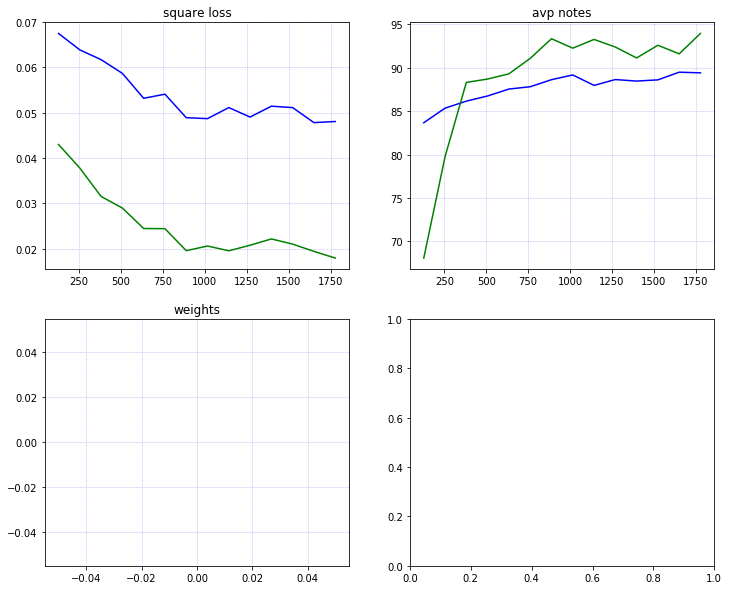

In [9]:
model.restore_checkpoint()
plt = media.PlotFormatter()
plt.plot('square loss',model.stats['loss_tr'][2],color='b')
plt.plot('square loss',model.stats['loss_ts'][2],color='g',share=True)
plt.plot('avp notes',model.stats['avp_tr'][2],color='b')
plt.plot('avp notes',model.stats['avp_ts'][2],color='g',share=True)
plt.plot('weights',model.sum_weights('beta'),color='g')
plt.show()

In [10]:
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=128,drop_last=False,num_workers=1)
yhat,y = model.predict_all(test_loader)

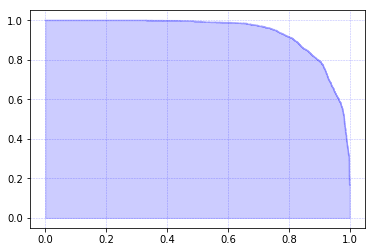

In [11]:
media.plot_pr_curve(y,yhat)

In [13]:
from sklearn.metrics import precision_recall_fscore_support
p,r,f,_ = precision_recall_fscore_support(y.ravel(),yhat.ravel()>.4,average='binary')
print(p,r,f)

0.9201590700520037 0.7928307854507116 0.8517627070649866
